# Binary logistic regression

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import jax
from jax import numpy as jnp, grad
import sklearn.datasets as skldata

# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

def logistic_loss(w, X, y, mu=1):
    m, n = X.shape
    return jnp.sum(jnp.logaddexp(0, -y * (X @ w))) / m + mu / 2 * jnp.sum(w**2)

def generate_problem(m=1000, n=300, mu=1):
    X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//2, random_state=0)
    X = jnp.array(X)
    y = jnp.array(y)
    return X, y

def compute_optimal(X, y, mu):
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum(cp.logistic(cp.multiply(-y, X @ w))) / len(y) + mu / 2 * cp.norm(w, 2)**2)
    problem = cp.Problem(objective)
    problem.solve()
    return w.value, problem.value

def stochastic_gradient_descent(X, y, x_0, learning_rate, iterations, batch_size=1, mu=0):
    m, n = X.shape
    x = x_0
    flops = 0
    trajectory = [x]
    flops_trajectory = [flops]
    for _ in range(iterations):
        indices = np.random.choice(m, batch_size, replace=False)
        X_batch, y_batch = X[indices], y[indices]
        f_batch = lambda w: logistic_loss(w, X=X_batch, y=y_batch, mu=mu)
        grad_f_batch = grad(f_batch)
        x -= learning_rate * grad_f_batch(x)
        trajectory.append(x)
        flops += (2 * n * batch_size + n)
        flops_trajectory.append(flops)
    return trajectory, flops_trajectory

def sag(X, y, x_0, learning_rate, iterations, batch_size=1, mu=0):
    m, n = X.shape
    x = x_0
    gradients = jnp.zeros((m, n))
    average_grad = jnp.zeros(n)
    flops = 0
    trajectory = [x]
    flops_trajectory = [flops]
    for _ in range(iterations):
        indices = np.random.choice(m, batch_size, replace=False)
        for idx in indices:
            f_i = lambda w: logistic_loss(w, X[idx:idx+1], y[idx:idx+1], mu=mu)
            grad_f_i = grad(f_i)
            new_grad = grad_f_i(x)
            average_grad += (new_grad - gradients[idx]) / m
            gradients = gradients.at[idx].set(new_grad)
        x -= learning_rate * average_grad
        trajectory.append(x)
        flops += (2 * n * batch_size + n)
        flops_trajectory.append(flops)
    return trajectory, flops_trajectory

def svrg(X, y, x_0, learning_rate, epoch_length, iterations, batch_size=1, mu=0):
    m, n = X.shape
    x = x_0
    flops = 0
    trajectory = [x]
    flops_trajectory = [flops]
    for _ in range(iterations // epoch_length):
        full_grad = grad(lambda w: logistic_loss(w, X, y, mu))(x)
        x_tilde = x
        for _ in range(epoch_length):
            indices = np.random.choice(m, batch_size, replace=False)
            X_batch, y_batch = X[indices], y[indices]
            grad_f_batch = grad(lambda w: logistic_loss(w, X_batch, y_batch, mu))
            grad_f_batch_tilde = grad(lambda w: logistic_loss(w, X_batch, y_batch, mu))(x_tilde)
            x -= learning_rate * (grad_f_batch(x) - grad_f_batch_tilde + full_grad)
            trajectory.append(x)
            flops += (4 * n * batch_size + 2 * n)
            flops_trajectory.append(flops)
    return trajectory, flops_trajectory

def compute_metrics(trajectory, x_star, f_star, f, flops_trajectory):
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "flops": flops_trajectory,
    }
    return metrics

def run_experiments(params):
    m, n, mu = params["m"], params["n"], params["mu"]
    methods = params["methods"]
    results = {}

    X, y = generate_problem(m, n, mu)
    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n,))
    # Compute the optimal solution using CVXPY
    x_star, f_star = compute_optimal(X, y, mu)

    for method_params in methods:
        method = method_params["method"]
        if method == "SGD":
            trajectory, flops_trajectory = stochastic_gradient_descent(
                X, y, x_0, method_params["learning_rate"], method_params["iterations"], method_params["batch_size"], mu
            )
        elif method == "SAG":
            trajectory, flops_trajectory = sag(
                X, y, x_0, method_params["learning_rate"], method_params["iterations"], method_params["batch_size"], mu
            )
        elif method == "SVRG":
            trajectory, flops_trajectory = svrg(
                X, y, x_0, method_params["learning_rate"], method_params["epoch_length"], method_params["iterations"], method_params["batch_size"], mu
            )
        label = f"{method} batch {method_params['batch_size']}"
        results[label] = compute_metrics(trajectory, x_star, f_star, f=lambda x: logistic_loss(x, X, y, mu), flops_trajectory=flops_trajectory)
    return results

def plot_results(results, params):
    plt.figure(figsize=(10, 3.5))
    mu = params["mu"]
    m = params["m"]
    n = params["n"]

    if mu > 1e-2:
        plt.suptitle(f"Strongly convex binary logistic regression. m={m}, n={n}, mu={mu}.")
    else:
        plt.suptitle(f"Convex binary logistic regression. m={m}, n={n}, mu={mu}.")

    plt.subplot(1, 3, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(1, 3, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method)
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(1, 3, 3)
    for method, metrics in results.items():
        plt.plot(metrics["flops"], metrics['f_gap'])
    plt.xlabel('FLOPS')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(f"sgd_{mu}_{m}_{n}.pdf")
    plt.show()

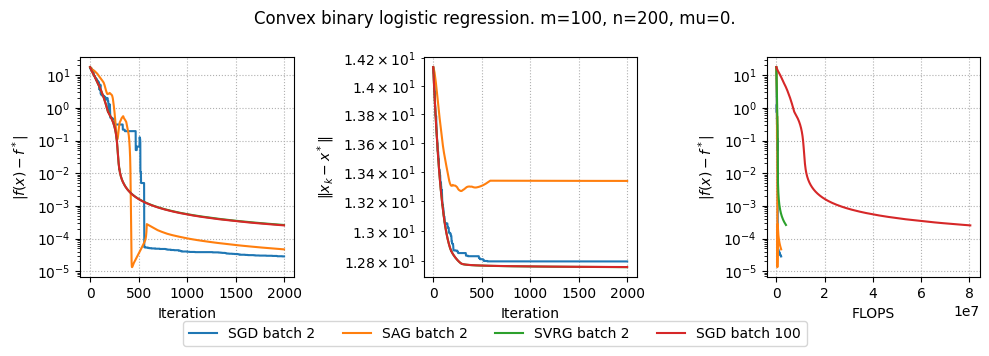

In [9]:
params = {
    "mu": 0,
    "m": 100,
    "n": 200,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SAG",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SVRG",
            "learning_rate": 1e-2,
            "epoch_length": 3,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 100,
            "iterations": 2000,
        },
    ]
}

results = run_experiments(params)
plot_results(results, params)

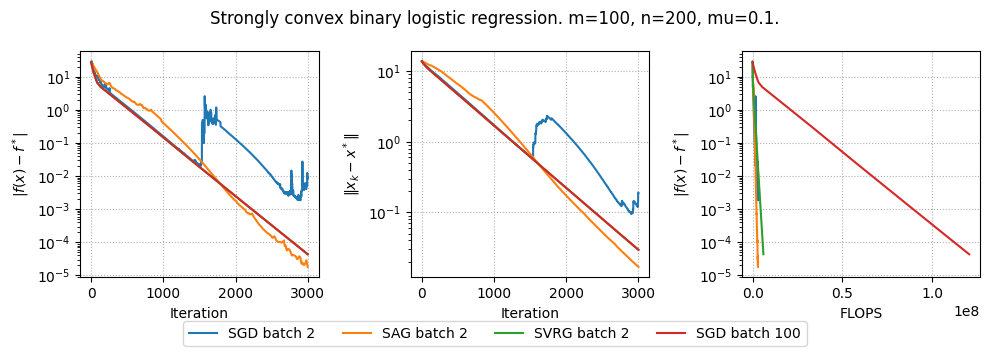

In [10]:
params = {
    "mu": 1e-1,
    "m": 100,
    "n": 200,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 2e-2,
            "batch_size": 2,
            "iterations": 3000,
        },
        {
            "method": "SAG",
            "learning_rate": 2e-2,
            "batch_size": 2,
            "iterations": 3000,
        },
        {
            "method": "SVRG",
            "learning_rate": 2e-2,
            "epoch_length": 3,
            "batch_size": 2,
            "iterations": 3000,
        },
        {
            "method": "SGD",
            "learning_rate": 2e-2,
            "batch_size": 100,
            "iterations": 3000,
        },
    ]
}

results = run_experiments(params)
plot_results(results, params)

Опять же, комментарии примерно такие же как для квадратичной задачи так как гарантии сходимости зависят от выпуклости задачи.

# Linear least squares

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import jax
from jax import numpy as jnp, grad
import sklearn.datasets as skldata

# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

def least_squares_loss(w, X, y, mu=1):
    m, n = X.shape
    residuals = X @ w - y
    return jnp.sum(residuals ** 2) / (2 * m) + mu / 2 * jnp.sum(w ** 2)

def generate_problem(m=1000, n=300, mu=1):
    X, y = skldata.make_regression(n_features=n, n_samples=m, noise=1e-3, random_state=0)
    X = jnp.array(X)
    y = jnp.array(y)
    return X, y

def compute_optimal(X, y, mu):
    w = cp.Variable(X.shape[1])
    residuals = X @ w - y
    objective = cp.Minimize(cp.sum_squares(residuals) / (2 * len(y)) + mu / 2 * cp.norm(w, 2)**2)
    problem = cp.Problem(objective)
    problem.solve()
    return w.value, problem.value

def stochastic_gradient_descent(X, y, x_0, learning_rate, iterations, batch_size=1, mu=1):
    m, n = X.shape
    x = x_0
    flops = 0
    trajectory = [x]
    flops_trajectory = [flops]
    for _ in range(iterations):
        indices = np.random.choice(m, batch_size, replace=False)
        X_batch, y_batch = X[indices], y[indices]
        f_batch = lambda w: least_squares_loss(w, X=X_batch, y=y_batch, mu=mu)
        grad_f_batch = grad(f_batch)
        x -= learning_rate * grad_f_batch(x)
        trajectory.append(x)
        flops += (2 * n * batch_size + n)
        flops_trajectory.append(flops)
    return trajectory, flops_trajectory

def sag(X, y, x_0, learning_rate, iterations, batch_size=1, mu=1):
    m, n = X.shape
    x = x_0
    gradients = jnp.zeros((m, n))
    average_grad = jnp.zeros(n)
    flops = 0
    trajectory = [x]
    flops_trajectory = [flops]
    for _ in range(iterations):
        indices = np.random.choice(m, batch_size, replace=False)
        for idx in indices:
            f_i = lambda w: least_squares_loss(w, X[idx:idx+1], y[idx:idx+1], mu=mu)
            grad_f_i = grad(f_i)
            new_grad = grad_f_i(x)
            average_grad += (new_grad - gradients[idx]) / m
            gradients = gradients.at[idx].set(new_grad)
        x -= learning_rate * average_grad
        trajectory.append(x)
        flops += (2 * n * batch_size + n)
        flops_trajectory.append(flops)
    return trajectory, flops_trajectory

def svrg(X, y, x_0, learning_rate, epoch_length, iterations, batch_size=1, mu=1):
    m, n = X.shape
    x = x_0
    flops = 0
    trajectory = [x]
    flops_trajectory = [flops]
    for _ in range(iterations // epoch_length):
        full_grad = grad(lambda w: least_squares_loss(w, X, y, mu))(x)
        x_tilde = x
        for _ in range(epoch_length):
            indices = np.random.choice(m, batch_size, replace=False)
            X_batch, y_batch = X[indices], y[indices]
            grad_f_batch = grad(lambda w: least_squares_loss(w, X_batch, y_batch, mu))
            grad_f_batch_tilde = grad(lambda w: least_squares_loss(w, X_batch, y_batch, mu))(x_tilde)
            x -= learning_rate * (grad_f_batch(x) - grad_f_batch_tilde + full_grad)
            trajectory.append(x)
            flops += (4 * n * batch_size + 2 * n)
            flops_trajectory.append(flops)
    return trajectory, flops_trajectory

def compute_metrics(trajectory, x_star, f_star, f, flops_trajectory):
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "flops": flops_trajectory,
    }
    return metrics

def run_experiments(params):
    m, n, mu = params["m"], params["n"], params["mu"]
    methods = params["methods"]
    results = {}

    X, y = generate_problem(m, n, mu)
    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n,))
    # Compute the optimal solution using CVXPY
    x_star, f_star = compute_optimal(X, y, mu)

    for method_params in methods:
        method = method_params["method"]
        if method == "SGD":
            trajectory, flops_trajectory = stochastic_gradient_descent(
                X, y, x_0, method_params["learning_rate"], method_params["iterations"], method_params["batch_size"], mu
            )
        elif method == "SAG":
            trajectory, flops_trajectory = sag(
                X, y, x_0, method_params["learning_rate"], method_params["iterations"], method_params["batch_size"], mu
            )
        elif method == "SVRG":
            trajectory, flops_trajectory = svrg(
                X, y, x_0, method_params["learning_rate"], method_params["epoch_length"], method_params["iterations"], method_params["batch_size"], mu
            )
        label = f"{method} batch {method_params['batch_size']}"
        results[label] = compute_metrics(trajectory, x_star, f_star, f=lambda x: least_squares_loss(x, X, y, mu), flops_trajectory=flops_trajectory)
    return results

def plot_results(results, params):
    plt.figure(figsize=(10, 3.5))
    mu = params["mu"]
    m = params["m"]
    n = params["n"]

    if mu > 1e-2:
        plt.suptitle(f"Strongly convex quadratics. m={m}, n={n}, mu={mu}.")
    else:
        plt.suptitle(f"Convex quadratics. m={m}, n={n}, mu={mu}.")

    plt.subplot(1, 3, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(1, 3, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method)
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(1, 3, 3)
    for method, metrics in results.items():
        plt.plot(metrics["flops"], metrics['f_gap'])
    plt.xlabel('FLOPS')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(f"sgd_{mu}_{m}_{n}.pdf")
    plt.show()

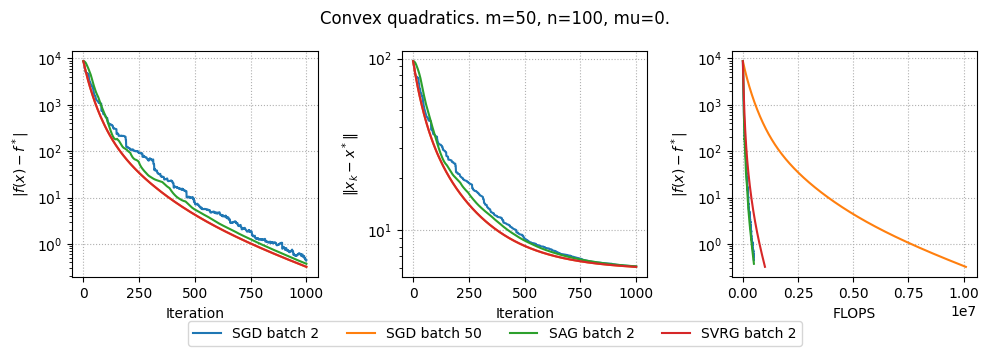

In [6]:
params = {
    "mu": 0,
    "m": 50,
    "n": 100,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 1000,
        },
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 50,
            "iterations": 1000,
        },
        {
            "method": "SAG",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 1000,
        },
        {
            "method": "SVRG",
            "learning_rate": 1e-2,
            "epoch_length": 2,
            "batch_size": 2,
            "iterations": 1000,
        },
    ]
}

results = run_experiments(params)
plot_results(results, params)

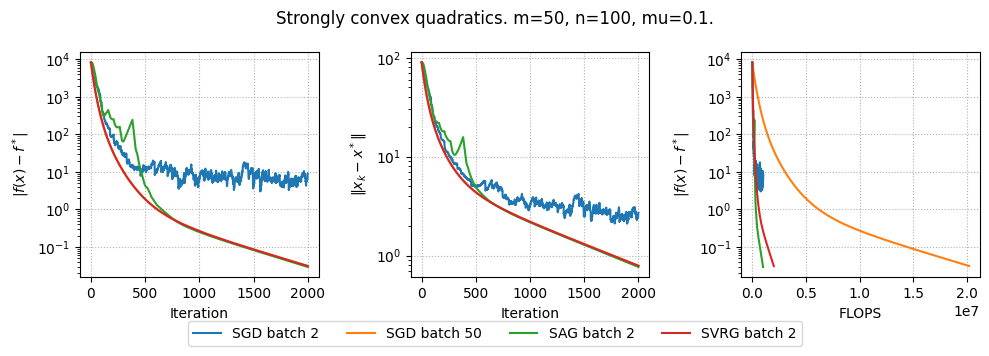

In [7]:
params = {
    "mu": 1e-1,
    "m": 50,
    "n": 100,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 50,
            "iterations": 2000,
        },
        {
            "method": "SAG",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SVRG",
            "learning_rate": 1e-2,
            "epoch_length": 2,
            "batch_size": 2,
            "iterations": 2000,
        },
    ]
}

results = run_experiments(params)
plot_results(results, params)

Видно что даже при очень маленьком размере батча скорость сходимости вырастает в сильно выпуклом случае. В просто выпуклом случае разница не настолько очевидна. В выпуклом случае мы наблюдаем сублинейную сходимость для всех методов, в сильно выпуклом случае из-за маленького размера батча сходимость для методов редукции дисперсии тоже скорее напомниает сублинейную(из-за очень большой константы), для sgd обычная сублинейная сходимость.